In [118]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

In [119]:
df=pd.read_csv("AAPL.csv")
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1980-12-12,0.128348,0.128906,0.128348,0.128348,0.099449,469033600
1,1980-12-15,0.122210,0.122210,0.121652,0.121652,0.094261,175884800
2,1980-12-16,0.113281,0.113281,0.112723,0.112723,0.087343,105728000
3,1980-12-17,0.115513,0.116071,0.115513,0.115513,0.089504,86441600
4,1980-12-18,0.118862,0.119420,0.118862,0.118862,0.092099,73449600


In [120]:
# Convert 'Date' to datetime

df['Date']=pd.to_datetime(df['Date'])

In [121]:
df=df[['Date', 'Close']]


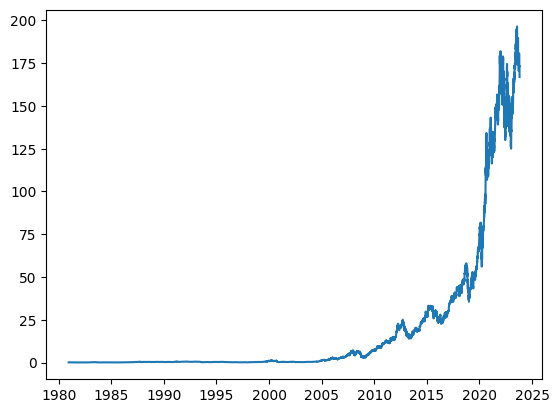

In [122]:
plt.plot(df['Date'], df['Close'])

In [123]:
shifts=[-1, -2, -3, -4]
#Create a function that adds columns corresponding to time T+1 until T=Target
def add_shifted_columns(df, shifts):
  for idx, shift_val in enumerate(shifts):
    df_temp=df['Close'].shift(shift_val)
    if idx<(len(shifts)-1):
      col_name=f'Target-{idx+1}'
    else:
      col_name='Target'
    df[col_name]=df_temp
    df['Target Date']=df['Date'].shift(-len(shifts))
  return df


In [124]:
#Modify our dataframe with the add_shifted_columns function

cutoff_date='2020-01-01'
df=df.loc[df['Date']>cutoff_date]
df1=add_shifted_columns(df, [-1, -2, -3, -4])




<ipython-input-123-87ac060510af>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col_name]=df_temp
<ipython-input-123-87ac060510af>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Target Date']=df['Date'].shift(-len(shifts))
<ipython-input-123-87ac060510af>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

In [125]:
df1=df1.drop(['Date', 'Close'],axis=1)
cols = ['Target Date'] + [col for col in df1 if col != 'Target Date']
df1 = df1[cols]
df1

,Target Date,Target-1,Target-2,Target-3,Target
9847,2020-01-08,74.357498,74.949997,74.597504,75.797501
9848,2020-01-09,74.949997,74.597504,75.797501,77.407501
9849,2020-01-10,74.597504,75.797501,77.407501,77.582497
9850,2020-01-13,75.797501,77.407501,77.582497,79.239998
9851,2020-01-14,77.407501,77.582497,79.239998,78.169998
...,...,...,...,...,...
10804,2023-10-26,173.000000,173.440002,171.100006,166.889999
10805,NaT,173.440002,171.100006,166.889999,NaN
10806,NaT,171.100006,166.889999,NaN,NaN
10807,NaT,166.889999,NaN,NaN,NaN


In [126]:
def extract_dates_features_target(df_reorganized):
    #Exctracting dates
    dates = df_reorganized.iloc[:, 0].values

    #Extracting features
    X = df_reorganized.iloc[:, 1:-1].values.reshape(-1, df_reorganized.shape[1] - 2, 1).astype(np.float32)

    #Extraire the target
    Y = df_reorganized.iloc[:, -1].values.astype(np.float32)

    return dates, X, Y

dates, X, Y = extract_dates_features_target(df1)

dates.shape, X.shape, Y.shape


((962,), (962, 3, 1), (962,))

In [129]:
def split_data(dates, X, y, train_ratio=0.8, val_ratio=0.1):
    train_idx = int(len(dates) * train_ratio)
    val_idx = train_idx + int(len(dates) * val_ratio)

    dates_train, X_train, Y_train = dates[:train_idx], X[:train_idx], Y[:train_idx]
    dates_val, X_val, Y_val = dates[train_idx:val_idx], X[train_idx:val_idx], Y[train_idx:val_idx]
    dates_test, X_test, Y_test = dates[val_idx:], X[val_idx:], Y[val_idx:]

    return (dates_train, X_train, Y_train), (dates_val, X_val, Y_val), (dates_test, X_test, Y_test)

(dates_train, X_train, Y_train), (dates_val, X_val, Y_val), (dates_test, X_test, Y_test) = split_data(dates, X, Y)



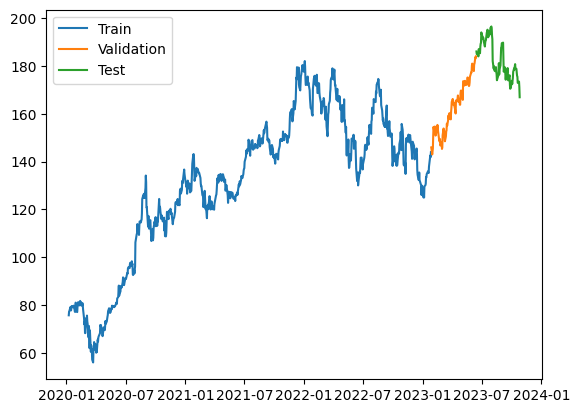

In [130]:
plt.plot(dates_train, Y_train)
plt.plot(dates_val, Y_val)
plt.plot(dates_test, Y_test)

plt.legend(['Train', 'Validation', 'Test'])

In [131]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

model = Sequential([layers.Input((3, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)

Epoch 1/100
25/25 [==============================] - 4s 32ms/step - loss: 17798.2148 - mean_absolute_error: 129.9805 - val_loss: 25965.5723 - val_mean_absolute_error: 160.7598
Epoch 2/100
25/25 [==============================] - 0s 5ms/step - loss: 16965.2227 - mean_absolute_error: 126.7238 - val_loss: 24308.1777 - val_mean_absolute_error: 155.5195
Epoch 3/100
25/25 [==============================] - 0s 6ms/step - loss: 14703.8271 - mean_absolute_error: 117.3048 - val_loss: 19165.9375 - val_mean_absolute_error: 137.9953
Epoch 4/100
25/25 [==============================] - 0s 6ms/step - loss: 8740.7480 - mean_absolute_error: 87.2172 - val_loss: 8545.0381 - val_mean_absolute_error: 91.7438
Epoch 5/100
25/25 [==============================] - 0s 6ms/step - loss: 2122.7561 - mean_absolute_error: 39.7576 - val_loss: 1324.9845 - val_mean_absolute_error: 34.6908
Epoch 6/100
25/25 [==============================] - 0s 7ms/step - loss: 873.9220 - mean_absolute_error: 23.0175 - val_loss: 890.190

25/25 [==============================] - 1s 2ms/step


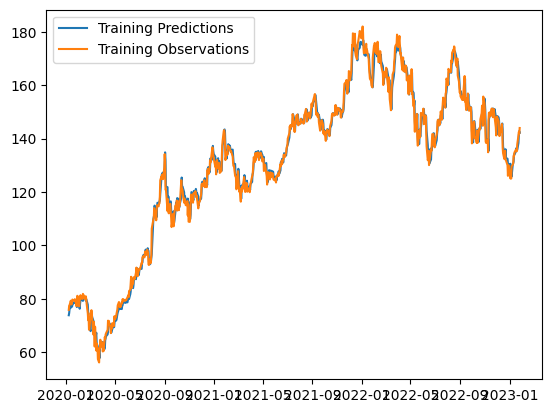

In [132]:
train_predictions = model.predict(X_train).flatten()

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])

3/3 [==============================] - 0s 4ms/step


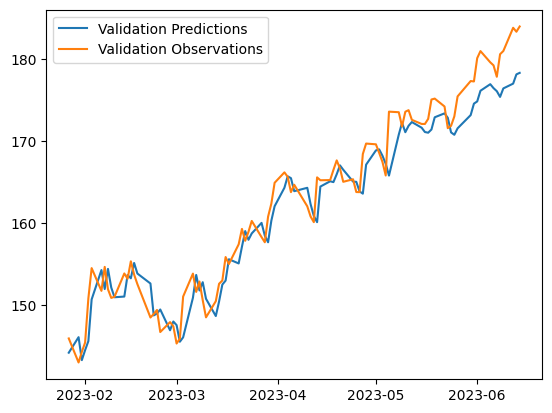

In [133]:
val_predictions = model.predict(X_val).flatten()

plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions', 'Validation Observations'])

4/4 [==============================] - 0s 3ms/step


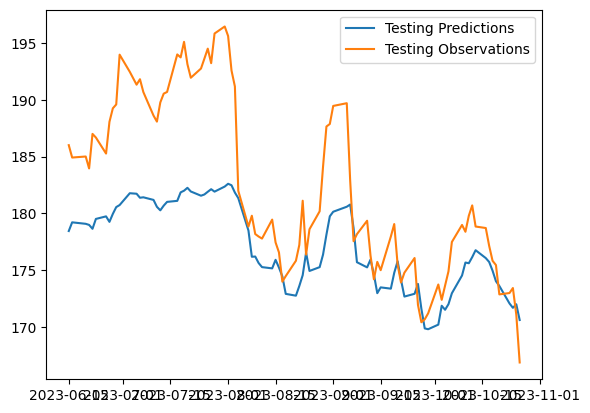

In [134]:
test_predictions = model.predict(X_test).flatten()

plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Testing Predictions', 'Testing Observations'])

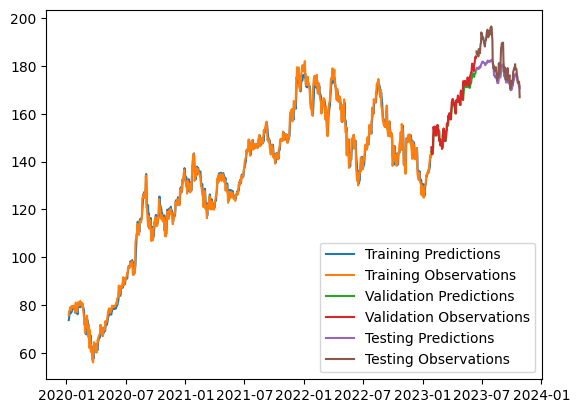

In [135]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Training Predictions',
            'Training Observations',
            'Validation Predictions',
            'Validation Observations',
            'Testing Predictions',
            'Testing Observations'])